In [8]:
import pandas as pd
from src.pca import plot_pca
from src.main import DataPreprocessor
import matplotlib.pyplot as plt

from src.get_data import read_precip, read_QTC
from src.preprocessing import clean_precip, clean_QTC
from src.plots import plot_interpolated_ts, plot_hydrographs
from src.split_events import split_events, filter_events
from src.EMUA import add_old_water
from src.h_index import get_h_index
from src.event_metrics import get_event_matrix

import warnings
warnings.filterwarnings("ignore")


In [9]:
#Data sources
precip_path = "./Data/2922906.csv"
QTC_path    = "./Data/formattedTimeSeries.csv"

# Get raw data
precip_raw = read_precip(precip_path)
QTC_raw    = read_QTC(QTC_path)

#Clean data
precip_clean = clean_precip(precip_raw) # resample to hourly P
QTC_clean = clean_QTC(QTC_raw) # interpolate small gaps, remove outliers

# add event flag
QTC_flagged = split_events(QTC_clean)

# Add old water estimation
QTCO = add_old_water(QTC_flagged)

# add TSS and Load
QTCO['TSS'] = QTCO['combinedTurb'].multiply(1.217).add(7.5215)
QTCO['load_mgs']=QTCO['TSS'].multiply(QTCO['Qcms'])

#filter events -> remove events with incomplete data 
Events_ts = filter_events(QTCO) # time series with flagged (final) events

#
Events_matrix = get_event_matrix(Events_ts, precip_clean, QTCO)



# Save results in local drive

In [ ]:
# File to be used by the model calibration algorithm 
output_path = './Outputs/Event_Matrix.csv'

Events_matrix.to_csv(output_path)

# Plots

## PCA plot

In [1]:
# data_file = './Outputs/Event_Matrix.csv'
# Events_matrix = pd.read_csv(data_file,
#                         header = [0,1],
#                         index_col = [0]
#                         )

Events_matrix.columns = Events_matrix.columns.get_level_values(1)

arrow_colors = ['k','b','r']
subset_predictors = ['P_15h_acum', 'load_30D', 'bf_qf_ratio']
X = Events_matrix.drop('h', axis = 1)
y = Events_matrix['h']

plot_pca(X, y, subset_predictors_plot = subset_predictors, arrow_colors = arrow_colors )


,h,peakFlow,Hours2Peak,DeltaQ,meanFlow,totFlow,cum_qf,mean_qf,max_qf,cum_bf,...,P_15h_acum,P_12h_max_i,P_15h_max_i,P_12h_mean_i,P_15h_mean_i,P_50d_acum,P_40d_acum,P_30d_acum,P_25d_acum,P_20d_acum
Event_ID,,,,,,,,,,,,,,,,,,,,,
9.0,0.017274,5.776637,5.00,5.537359,0.890828,2.260921e+05,6.501878e+04,0.256181,2.054566,1.610733e+05,...,0.56,0.32,0.32,0.173333,0.112000,8.25,6.55,5.12,4.05,3.18
14.0,-0.026414,4.360794,21.00,3.998339,1.875455,4.726147e+05,7.059147e+04,0.280125,1.644824,4.020232e+05,...,0.75,0.14,0.14,0.071429,0.071000,6.35,5.57,5.01,5.01,5.01
18.0,-0.105355,5.748320,6.00,5.238617,1.146516,4.612432e+05,6.913516e+04,0.171850,1.505357,3.921080e+05,...,0.42,0.35,0.35,0.105000,0.105000,7.61,4.28,3.54,2.70,1.85
19.0,-0.032844,4.983765,6.50,4.820660,0.981373,2.110933e+05,6.018939e+04,0.279821,1.143136,1.509040e+05,...,0.71,0.45,0.45,0.142000,0.142000,4.05,3.11,1.44,0.86,0.78
23.0,0.071117,7.645549,8.25,7.008420,2.381527,1.056684e+06,4.395789e+04,0.099071,1.636795,1.012726e+06,...,0.91,0.18,0.18,0.085556,0.082727,2.83,2.76,1.18,1.17,1.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135.0,0.377123,48.988145,10.50,44.995470,11.050116,1.979076e+06,1.137861e+06,6.353219,45.316960,8.412143e+05,...,1.11,0.36,0.38,0.167500,0.210000,7.43,6.35,5.99,5.86,4.65
136.0,0.201899,18.009515,4.75,14.186740,5.508329,1.199714e+06,1.529750e+05,0.702365,8.756697,1.046739e+06,...,0.87,0.63,0.63,0.290000,0.290000,9.23,8.04,7.77,7.66,5.71
137.0,-0.080184,4.898815,3.75,2.010496,3.237933,3.759240e+05,6.005714e+03,0.051729,0.331785,3.699183e+05,...,0.39,0.20,0.20,0.097500,0.097500,10.27,9.01,8.70,7.49,5.90


## Time Series

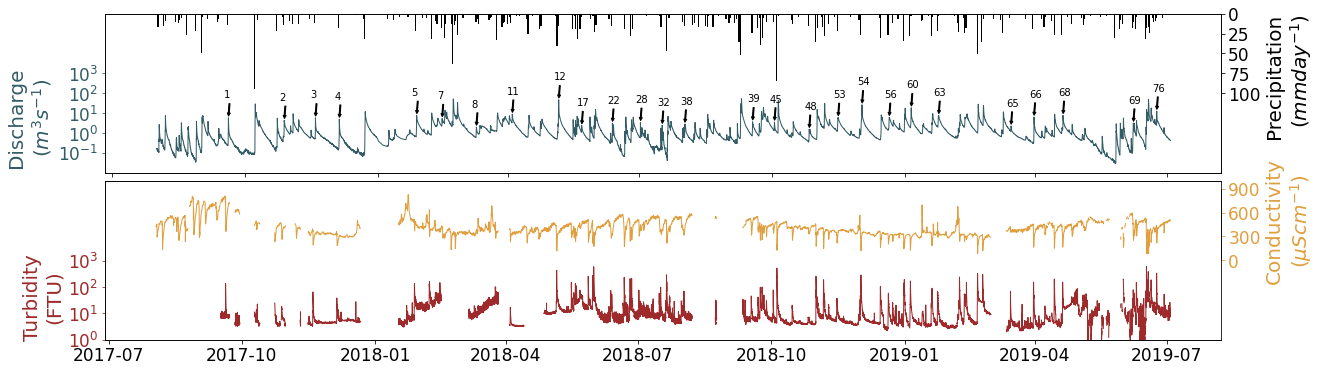

In [151]:
from src.time_series_plot import plot_time_series
plot_time_series(QTC_clean, precip_clean, Events_ts)